In [38]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
!pip install "gym[atari, accept-rom-license]"
!nvidia-smi
# the skeleton of the below code is obtained from the project: https://github.com/bhctsntrk/OpenAIPong-DQN/blob/master/README.md #

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Fri Mar  1 11:05:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    223MiB / 15360MiB |      0%      Default |
|                          

In [39]:
import gym
import cv2

import time
import json
import random
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
import matplotlib.pyplot as plt

In [40]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = False  # Load model from file
LOAD_FILE_EPISODE = 0  # Load Xth episode from file

BATCH_SIZE = 32  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 501  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.99  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.995  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

# Plotting data
episode_rewards = []
episode_steps = []
paddle_hits = []
serving_times = []
episode_durations = []
mean_last_100_ep_reward = []
mean_last_100_ep_steps = []
mean_last_100_paddle_hits = []
mean_last_100_ep_durations =[]
mean_last_100_serving_times =[]


In [41]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

In [42]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [43]:
environment = gym.make(ENVIRONMENT)  # Get env
agent = Agent(environment)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
last_100_ep_steps = deque(maxlen=100)  # Last 100 episode steps
last_100_paddle_hits = deque(maxlen=100)  # Last 100 paddle hits
last_100_ep_durations = deque(maxlen=100)  # Last 100 episode durations
last_100_serving_times = deque(maxlen=100)  # Last 100 serving times
total_step = 1  # Cumulkative sum of all steps in episodes

# Adjusted reward for each time step
REWARD_STEP = 0.001
REWARD_SCALE_FACTOR = 0.01 # Scale factor for logarithmic function
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    serving_start_time = None  # Initialize serving start time
    paddle_hit_count = 0  # Initialize paddle hit count
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    episode_duration = 0  # Initialize episode duration
    serving_start_time = None  # Initialize serving start time
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe
        # Calculate reward using logarithmic function
        reward = reward + (math.log(REWARD_STEP * step + 1) * REWARD_SCALE_FACTOR)







        # Count paddle hits
        if action in [1,3,5]:  # Actions correspond to move paddle up
            paddle_hit_count += 1

        # Check if the ball has been served and if the agent hits it for the first time
        if serving_start_time is None and action in [1, 4, 5]:  # Actions correspond to serving the ball
            serving_start_time = time.time()


        # Track serving time
        if serving_start_time is None:
            serving_start_time = time.time()

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem


        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            last_100_ep_steps.append(episode_steps)
            last_100_paddle_hits.append(paddle_hit_count)
            last_100_ep_durations.append(time_passed)
            last_100_serving_times.append(serving_start_time - startTime)  # Measure serving time from start to first action

            avg_max_q_val = total_max_q_val / step

            mean_reward = np.mean(last_100_ep_reward)
            mean_steps = np.mean(last_100_ep_steps)
            mean_paddle_hits = np.mean(last_100_paddle_hits)
            mean_durations = np.mean(last_100_ep_durations)
            mean_serving_times = np.mean(last_100_serving_times)

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Last_100_Avg_Duration:{:.3f} Step:{} Last_100_Avg_Steps:{:.3f} CStep:{} PaddleHits:{} Last_100_Avg_Paddle_Hits:{:.3f} Serving time:{} Last_100_Avg_Serving_Times:{:.3f}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, np.mean(last_100_ep_durations), step, np.mean(last_100_ep_steps), total_step, paddle_hit_count,np.mean(last_100_paddle_hits), serving_start_time, np.mean(last_100_serving_times)
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")
            # Collect data for plotting
            episode_rewards.append(total_reward)
            episode_steps.append(step)
            paddle_hits.append(paddle_hit_count)
            serving_times.append(serving_start_time - startTime)
            episode_durations.append(time_passed)
            mean_last_100_ep_reward.append(mean_reward)
            mean_last_100_ep_steps.append(mean_steps)
            mean_last_100_paddle_hits.append(mean_paddle_hits)
            mean_last_100_ep_durations.append(mean_durations)
            mean_last_100_serving_times.append(mean_serving_times)

            break





/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated

Episode:1 Time:11:05:07 Reward:-16.78 Loss:0.00 Last_100_Avg_Rew:-16.776 Avg_Max_Q:0.000 Epsilon:1.00 Duration:0.69 Last_100_Avg_Duration:0.685 Step:904 Last_100_Avg_Steps:nan CStep:906 PaddleHits:446 Last_100_Avg_Paddle_Hits:446.000 Serving time:1709291106.6652544 Last_100_Avg_Serving_Times:0.009
Episode:2 Time:11:05:08 Reward:-17.53 Loss:0.00 Last_100_Avg_Rew:-17.155 Avg_Max_Q:0.000 Epsilon:0.99 Duration:0.67 Last_100_Avg_Duration:0.676 Step:941 Last_100_Avg_Steps:904.000 CStep:1848 PaddleHits:478 Last_100_Avg_Paddle_Hits:462.000 Serving time:1709291107.352693 Last_100_Avg_Serving_Times:0.009
Episode:3 Time:11:05:08 Reward:-15.43 Loss:0.00 Last_100_Avg_Rew:-16.581 Avg_Max_Q:0.000 Epsilon:0.99 Duration:0.66 Last_100_Avg_Duration:0.669 Step:956 Last_100_Avg_Steps:922.500 CStep:2805 PaddleHits:467 Last_100_Avg_Paddle_Hits:463.667 Serving time:1709291108.020853 Last_100_Avg_Serving_Times:0.009
Episode:4 Time:11:05:09 Reward:-14.05 Loss:0.00 Last_100_Avg_Rew:-15.949 Avg_Max_Q:0.000 Epsilo

<Figure size 1200x1200 with 0 Axes>

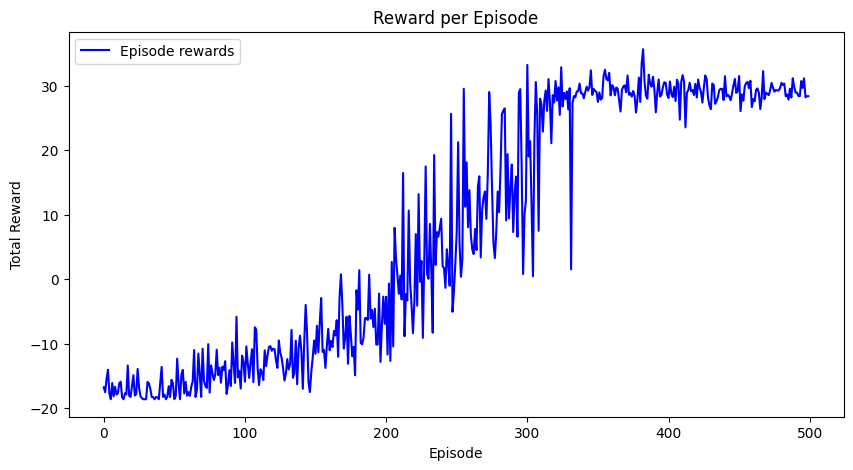

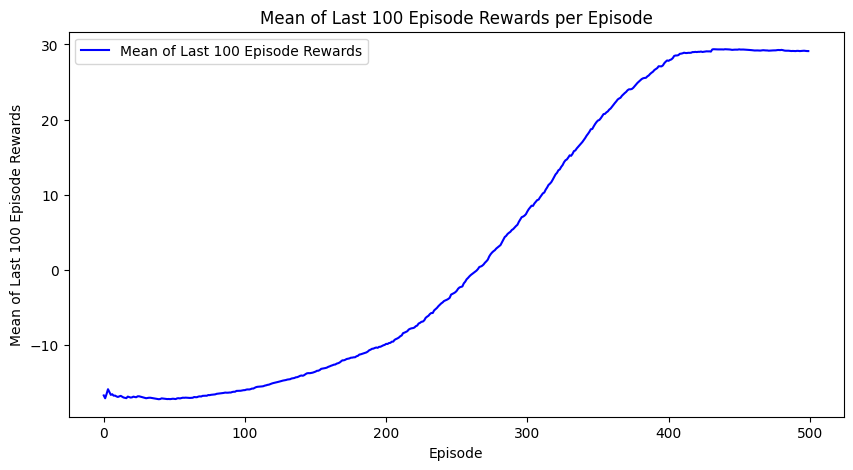

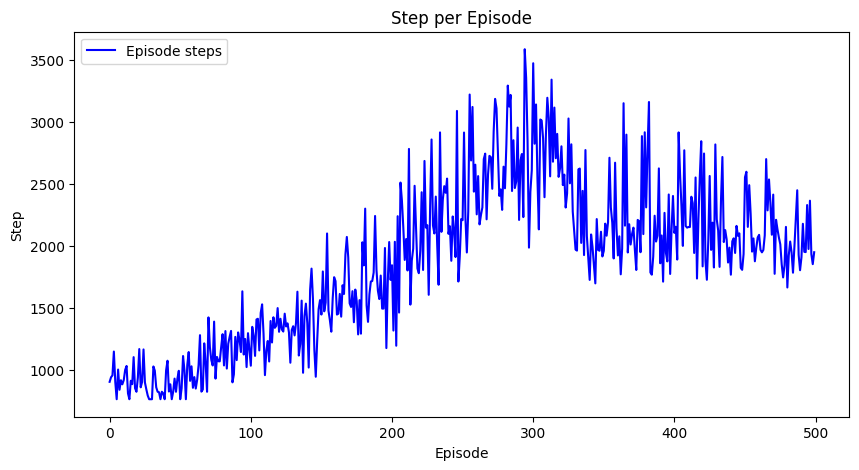

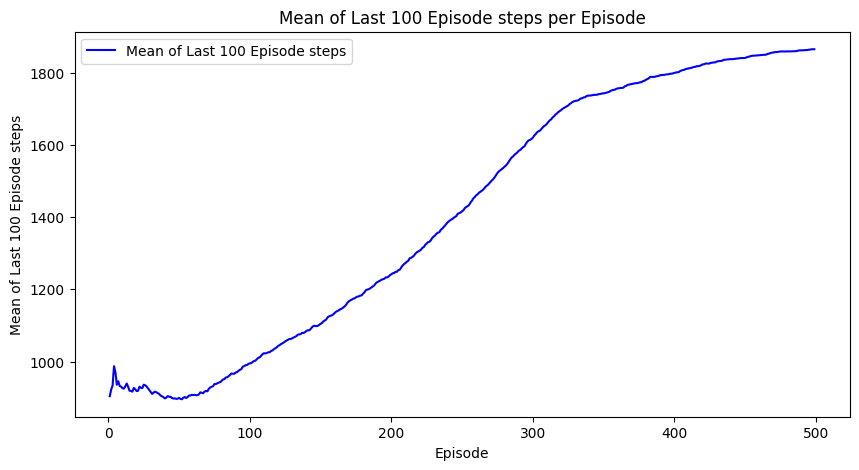

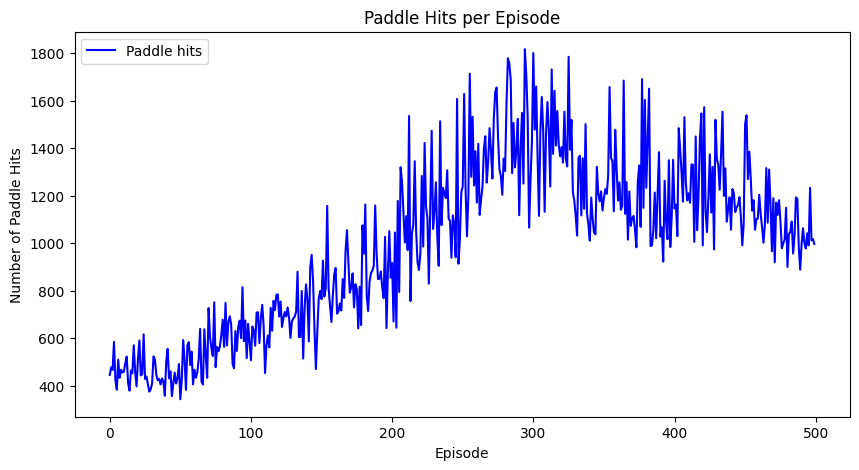

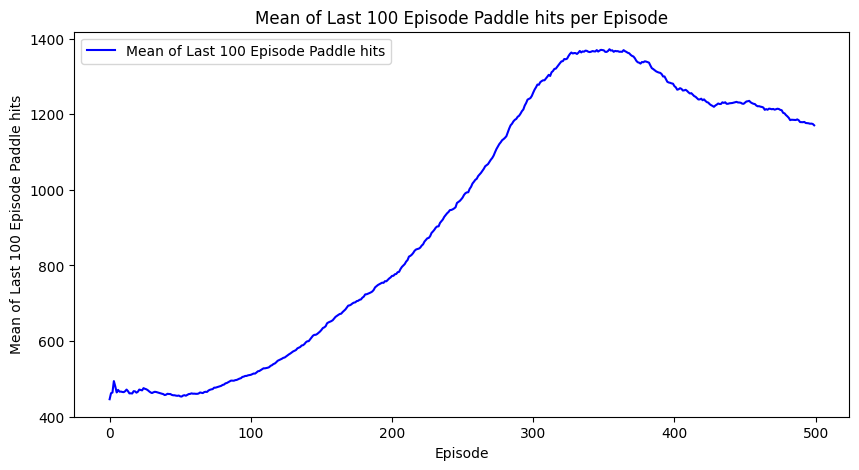

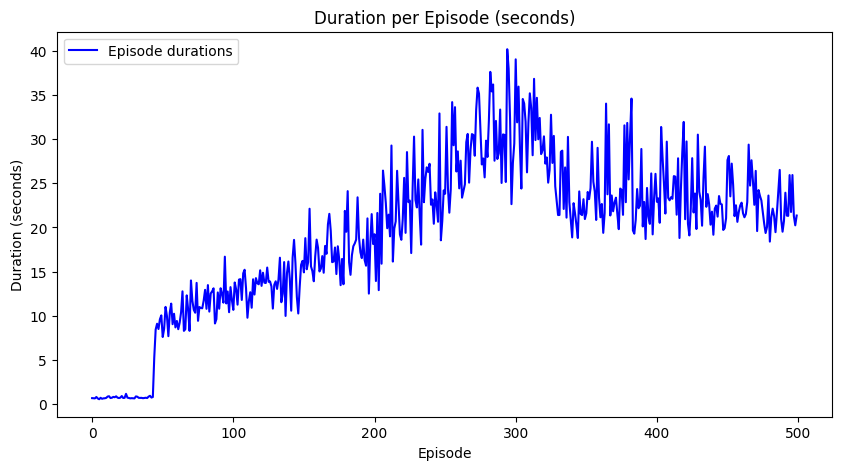

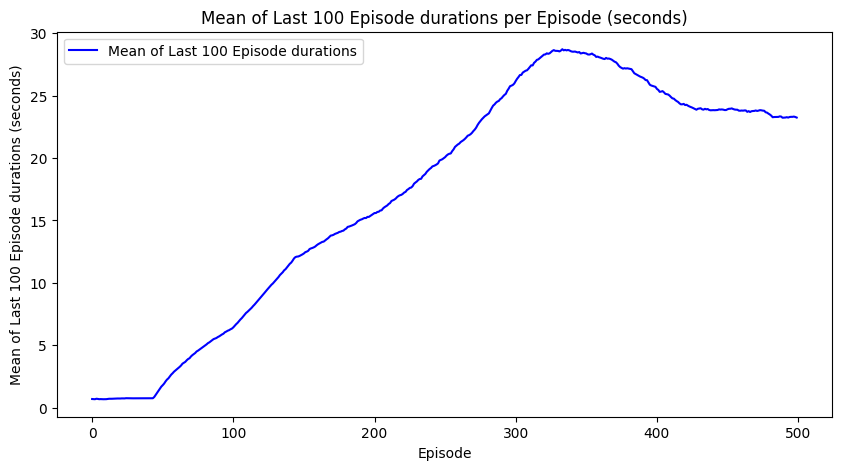

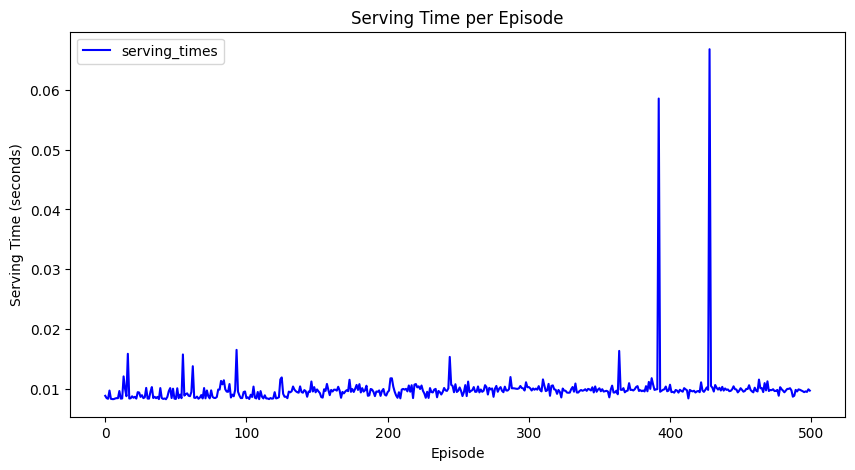

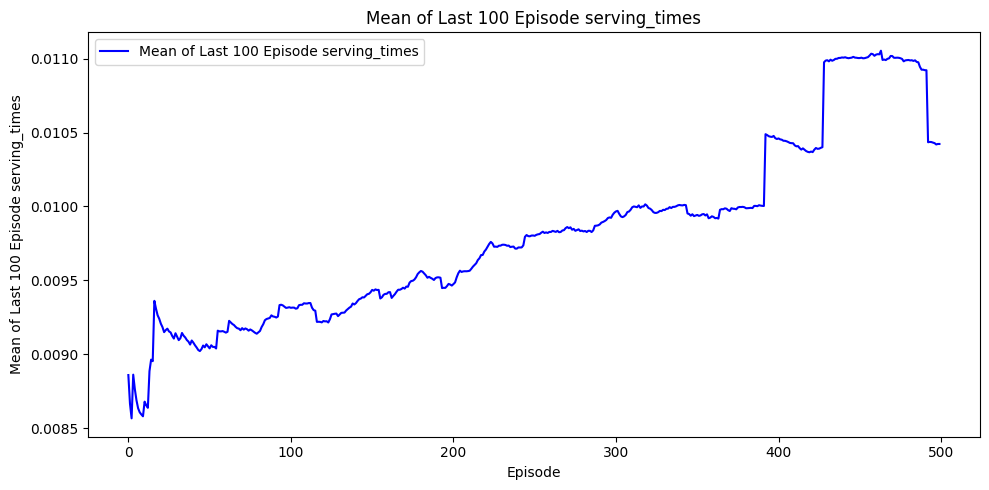

In [44]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(12, 12))

plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label = 'Episode rewards', c='b')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend(loc="upper left")
plt.savefig('Reward per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward, label = 'Mean of Last 100 Episode Rewards', c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper left")
plt.savefig('Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_steps, label = 'Episode steps', c='b')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.title('Step per Episode')
plt.legend(loc="upper left")
plt.savefig('Step per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps, label = 'Mean of Last 100 Episode steps', c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper left")
plt.savefig('Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(paddle_hits, label ='Paddle hits', c='b')
plt.xlabel('Episode')
plt.ylabel('Number of Paddle Hits')
plt.title('Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits, label ='Mean of Last 100 Episode Paddle hits', c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle hits')
plt.title('Mean of Last 100 Episode Paddle hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Mean of Last 100 Episode Paddle hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_durations, label = 'Episode durations', c='b')
plt.xlabel('Episode')
plt.ylabel('Duration (seconds)')
plt.title('Duration per Episode (seconds)')
plt.legend(loc="upper left")
plt.savefig('Duration per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations, label = 'Mean of Last 100 Episode durations', c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode durations (seconds)')
plt.title('Mean of Last 100 Episode durations per Episode (seconds)')
plt.legend(loc="upper left")
plt.savefig('Mean of Last 100 Episode durations.png')

plt.figure(figsize=(10,5))
plt.plot(serving_times, label ='serving_times', c='b')
plt.xlabel('Episode')
plt.ylabel('Serving Time (seconds)')
plt.title('Serving Time per Episode')
plt.legend(loc="upper left")
plt.savefig('Serving Time per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times, label ='Mean of Last 100 Episode serving_times', c='b')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode serving_times')
plt.title('Mean of Last 100 Episode serving_times')
plt.legend(loc="upper left")
plt.savefig('Mean of Last 100 Episode serving_times.png')

plt.tight_layout()
plt.show()

In [45]:
#Export data to Pandas Dataframe
import pandas as pd
df = pd.DataFrame(list(zip(episode_rewards,mean_last_100_ep_reward, episode_steps, mean_last_100_ep_steps, paddle_hits,mean_last_100_paddle_hits, episode_durations, mean_last_100_ep_durations, serving_times, mean_last_100_serving_times)),
               columns =['episode_rewards', 'mean_last_100_ep_reward', 'episode_steps', 'mean_last_100_ep_steps', 'paddle_hits','mean_last_100_paddle_hits','episode_durations','mean_last_100_ep_durations', 'serving_times', 'mean_last_100_serving_times'])
df.to_csv('/content/gdrive/MyDrive/Second_Method.csv')
df

,episode_rewards,mean_last_100_ep_reward,episode_steps,mean_last_100_ep_steps,paddle_hits,mean_last_100_paddle_hits,episode_durations,mean_last_100_ep_durations,serving_times,mean_last_100_serving_times
0,-16.775841,-16.775841,904,NaN,446,446.000000,0.685369,0.685369,0.008861,0.008861
1,-17.533908,-17.154874,941,904.000000,478,462.000000,0.666317,0.675843,0.008475,0.008668
2,-15.433811,-16.581187,956,922.500000,467,463.666667,0.656042,0.669243,0.008368,0.008568
3,-14.053919,-15.949370,1148,933.666667,585,494.000000,0.814482,0.705553,0.009749,0.008863
4,-17.782280,-16.315952,903,987.250000,424,480.000000,0.646646,0.693771,0.008372,0.008765
...,...,...,...,...,...,...,...,...,...,...
495,29.679308,29.155234,1974,1863.874747,991,1176.260000,21.750921,23.300808,0.009480,0.010432
496,31.163652,29.169132,2363,1864.096774,1233,1175.100000,25.934951,23.299003,0.009609,0.010428
497,28.235216,29.145907,1933,1865.100604,1012,1175.380000,21.295575,23.319798,0.009520,0.010419
498,28.374784,29.125112,1852,1865.236948,1018,1174.440000,20.243096,23.289447,0.009950,0.010423


In [46]:
#Import data from first method
plot_data=pd.read_csv('/content/gdrive/MyDrive/First_Method.csv')
First_Method_episode_rewards=plot_data['episode_rewards'].to_list()
First_Method_mean_last_100_ep_reward=plot_data['mean_last_100_ep_reward'].to_list()
First_Method_episode_steps=plot_data['episode_steps'].to_list()
First_Method_mean_last_100_ep_steps=plot_data['mean_last_100_ep_steps'].to_list()
First_Method_paddle_hits=plot_data['paddle_hits'].to_list()
First_Method_mean_last_100_paddle_hits=plot_data['mean_last_100_paddle_hits'].to_list()
First_Method_episode_durations=plot_data['episode_durations'].to_list()
First_Method_mean_last_100_ep_durations=plot_data['mean_last_100_ep_durations'].to_list()
First_Method_serving_times=plot_data['serving_times'].to_list()
First_Method_mean_last_100_serving_times=plot_data['mean_last_100_serving_times'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


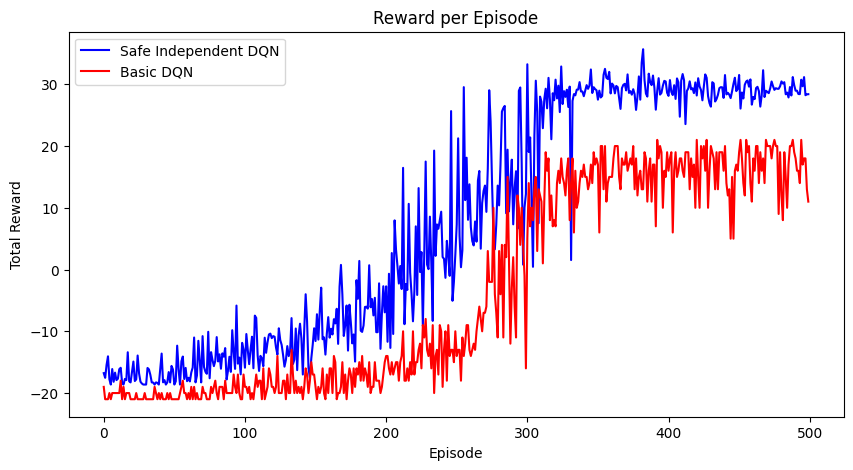

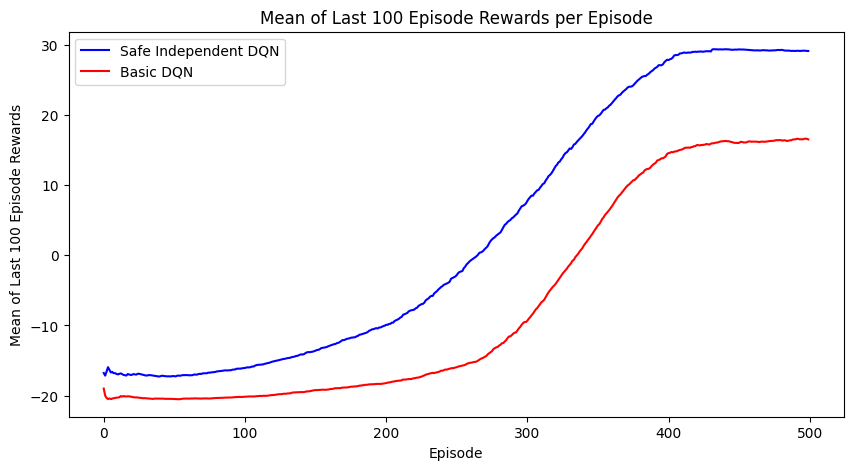

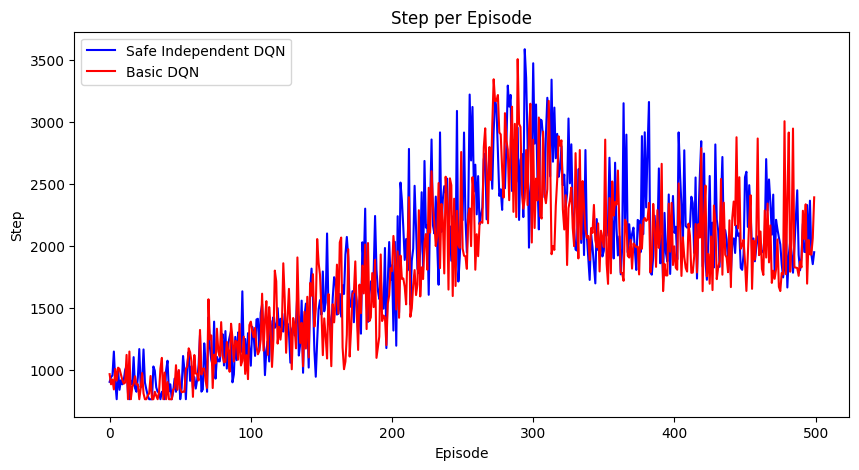

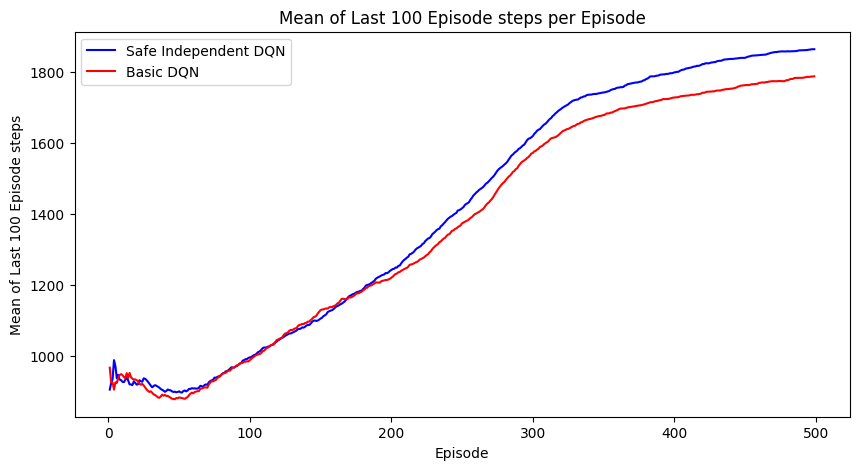

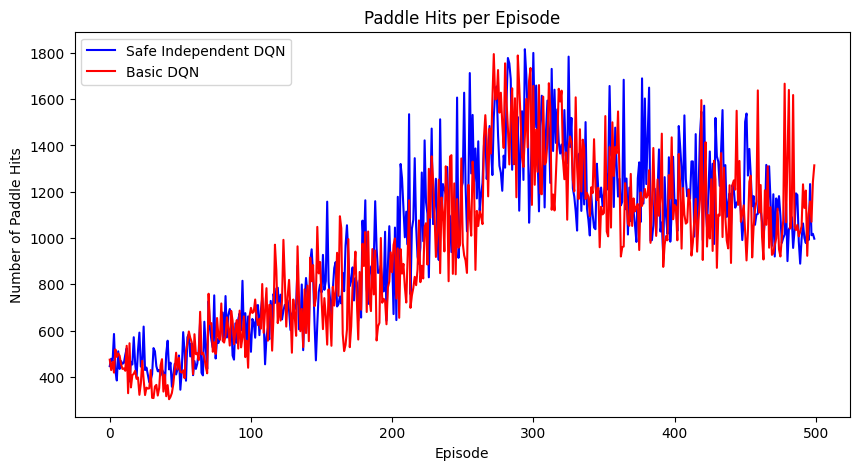

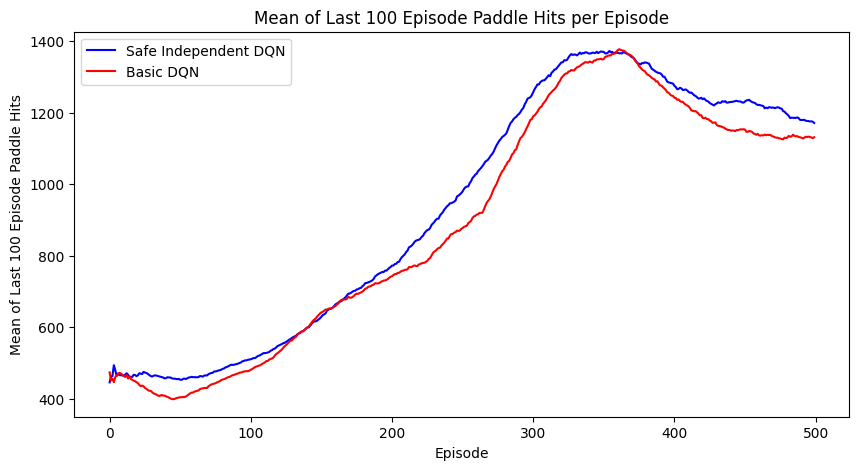

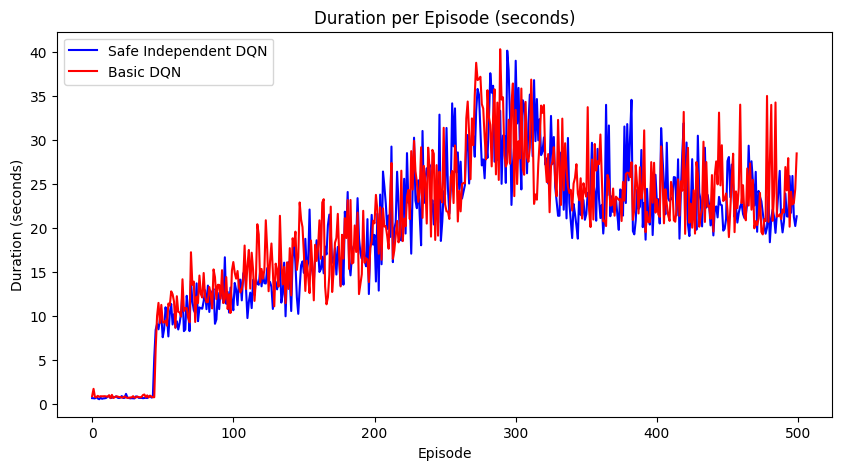

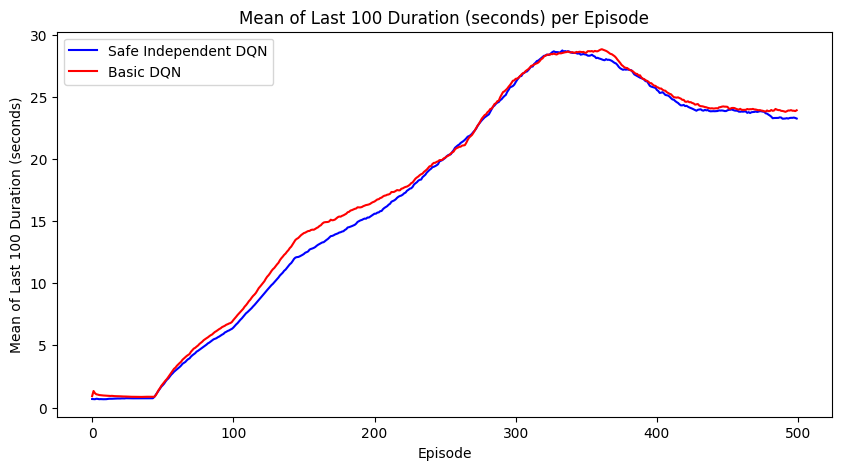

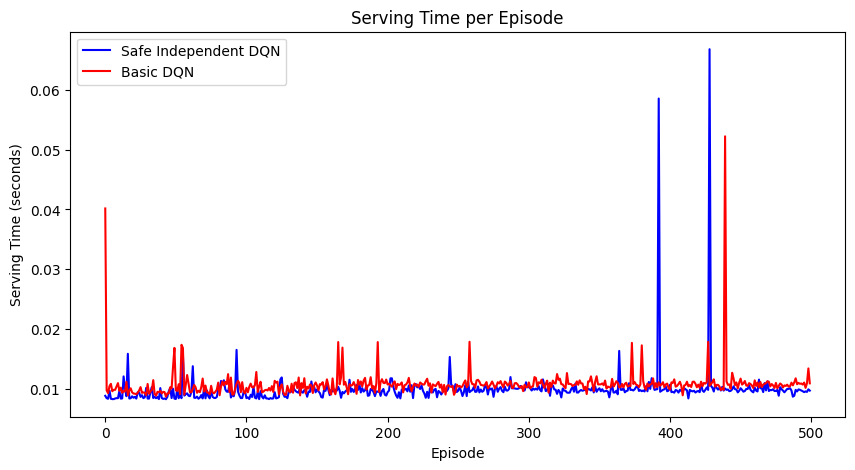

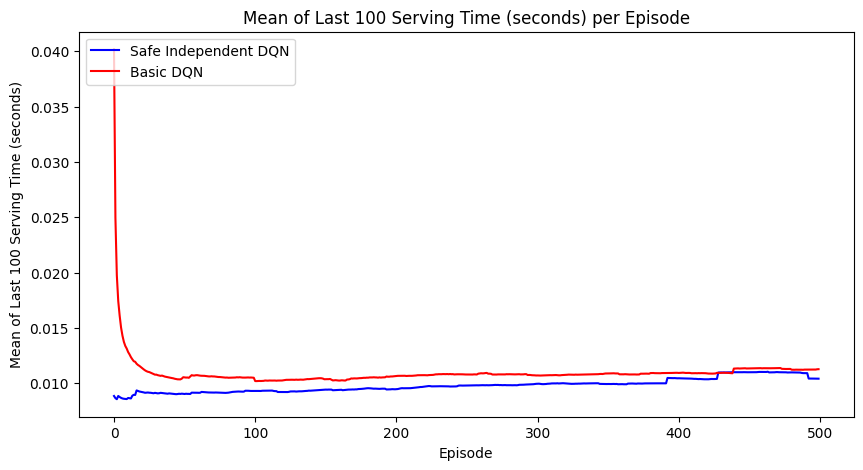

In [47]:
# Plotting comparison
plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_rewards, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Reward per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_reward, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_steps, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_steps, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.title('Step per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_steps, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(paddle_hits, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_paddle_hits, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Number of Paddle Hits')
plt.title('Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_paddle_hits, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle Hits')
plt.title('Mean of Last 100 Episode Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_durations, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_durations, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Duration (seconds)')
plt.title('Duration per Episode (seconds)')
plt.legend(loc="upper left")
plt.savefig('Comparison Duration per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_durations, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Duration (seconds)')
plt.title('Mean of Last 100 Duration (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Duration (seconds) per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(serving_times, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_serving_times, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Serving Time (seconds)')
plt.title('Serving Time per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Serving time per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_mean_last_100_serving_times, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Serving Time (seconds)')
plt.title('Mean of Last 100 Serving Time (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Serving Time (seconds) per Episode.png')

In [48]:
#Statistics

# Calculate mean and median and st dev
mean_reward = np.mean(episode_rewards)
median_reward = np.median(episode_rewards)
std_dev_reward = np.std(episode_rewards)

mean_duration = np.mean(episode_durations)
median_duration = np.median(episode_durations)
std_dev_duration = np.std(episode_durations)

mean_paddle_hits = np.mean(paddle_hits)
median_paddle_hits = np.median(paddle_hits)
std_dev_paddle_hits = np.std(paddle_hits)

mean_episode_steps = np.mean(episode_steps)
median_episode_steps = np.median(episode_steps)
std_dev_episode_steps = np.std(episode_steps)

mean_serving_time = np.mean(serving_times)
median_serving_time = np.median(serving_times)
std_dev_serving_time = np.std(serving_times)

# Print mean, median, and standard deviation values
print("Mean Reward:", mean_duration)
print("Median Reward:", median_duration)
print("Standard Deviation Reward:", std_dev_duration)

print("Mean Duration:", mean_duration)
print("Median Duration:", median_duration)
print("Standard Deviation Duration:", std_dev_duration)

print("Mean Paddle Hits:", mean_paddle_hits)
print("Median Paddle Hits:", median_paddle_hits)
print("Standard Deviation Paddle Hits:", std_dev_paddle_hits)

print("Mean Episode Steps:", mean_episode_steps)
print("Median Episode Steps:", median_episode_steps)
print("Standard Deviation Episode Steps:", std_dev_episode_steps)

print("Mean Serving Time:", mean_serving_time)
print("Median Serving Time:", median_serving_time)
print("Standard Deviation Serving Time:", std_dev_serving_time)

Mean Reward: 19.350082344532012
Median Reward: 21.038971185684204
Standard Deviation Reward: 8.741568409930565
Mean Duration: 19.350082344532012
Median Duration: 21.038971185684204
Standard Deviation Duration: 8.741568409930565
Mean Paddle Hits: 995.758
Median Paddle Hits: 1041.0
Standard Deviation Paddle Hits: 354.075691676229
Mean Episode Steps: 1865.376
Median Episode Steps: 1931.5
Standard Deviation Episode Steps: 639.1879775339958
Mean Serving Time: 0.009924259662628174
Median Serving Time: 0.00970458984375
Standard Deviation Serving Time: 0.003493454532242422


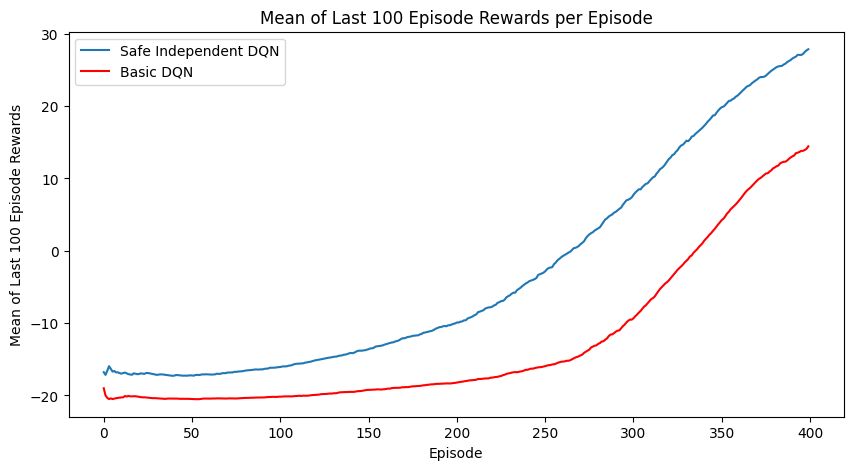

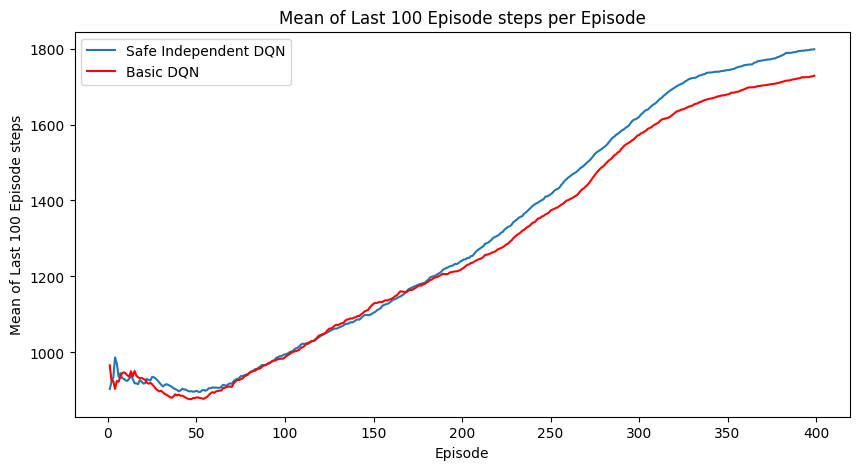

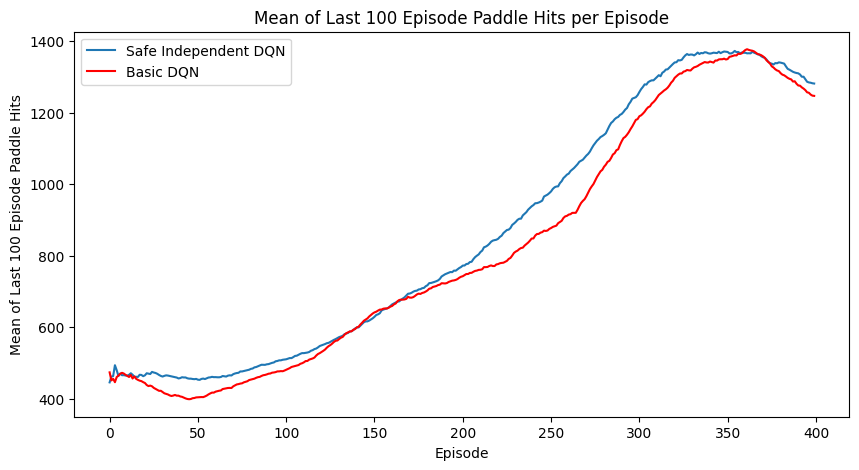

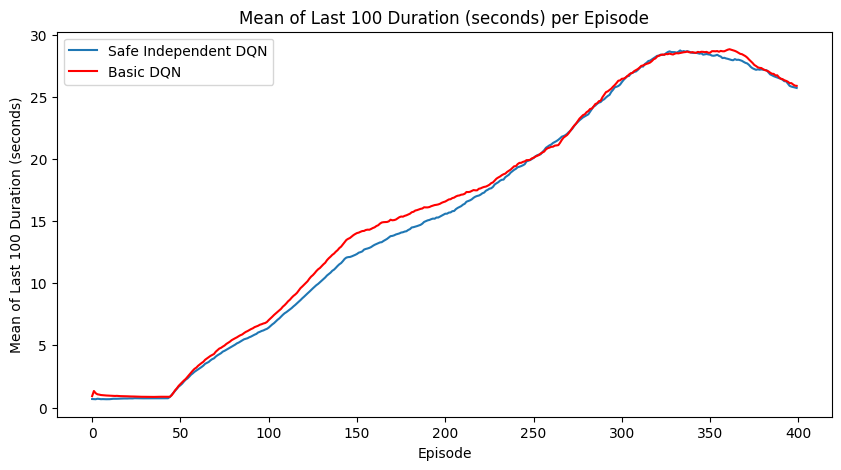

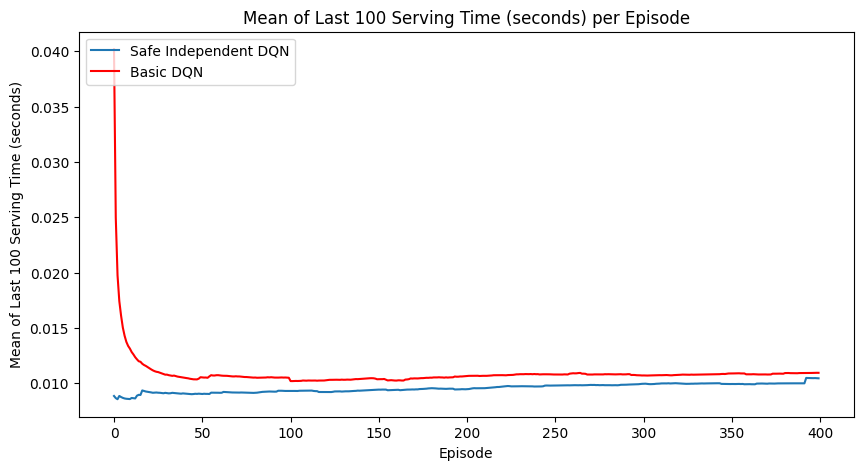

In [49]:
# Plot only first 400 episodes
plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward[:400], label='Safe Independent DQN')
plt.plot(First_Method_mean_last_100_ep_reward[:400], label="Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps[:400], label='Safe Independent DQN')
plt.plot(First_Method_mean_last_100_ep_steps[:400], label="Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits[:400], label='Safe Independent DQN')
plt.plot(First_Method_mean_last_100_paddle_hits[:400], label="Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle Hits')
plt.title('Mean of Last 100 Episode Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations[:400], label='Safe Independent DQN')
plt.plot(First_Method_mean_last_100_ep_durations[:400], label="Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Duration (seconds)')
plt.title('Mean of Last 100 Duration (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Duration (seconds) per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times[:400], label="Safe Independent DQN")
plt.plot(First_Method_mean_last_100_serving_times[:400], label="Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Serving Time (seconds)')
plt.title('Mean of Last 100 Serving Time (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Serving Time (seconds) per Episode.png')



In [50]:
#Import data from first method trial 6
plot_data=pd.read_csv('/content/gdrive/MyDrive/First_Method_trial6.csv')
First_Method_episode_rewards_trial6=plot_data['episode_rewards'].to_list()
First_Method_mean_last_100_ep_reward_trial6=plot_data['mean_last_100_ep_reward'].to_list()
First_Method_episode_steps_trial6=plot_data['episode_steps'].to_list()
First_Method_mean_last_100_ep_steps_trial6=plot_data['mean_last_100_ep_steps'].to_list()
First_Method_paddle_hits_trial6=plot_data['paddle_hits'].to_list()
First_Method_mean_last_100_paddle_hits_trial6=plot_data['mean_last_100_paddle_hits'].to_list()
First_Method_episode_durations_trial6=plot_data['episode_durations'].to_list()
First_Method_mean_last_100_ep_durations_trial6=plot_data['mean_last_100_ep_durations'].to_list()
First_Method_serving_times_trial6=plot_data['serving_times'].to_list()
First_Method_mean_last_100_serving_times_trial6=plot_data['mean_last_100_serving_times'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


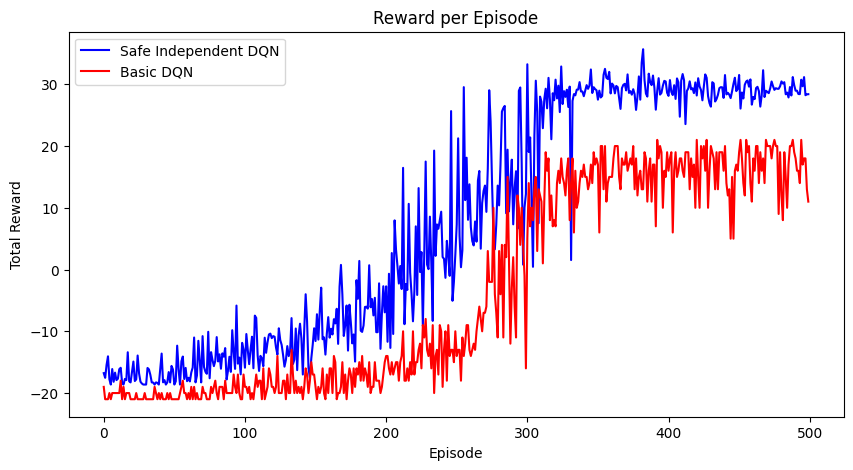

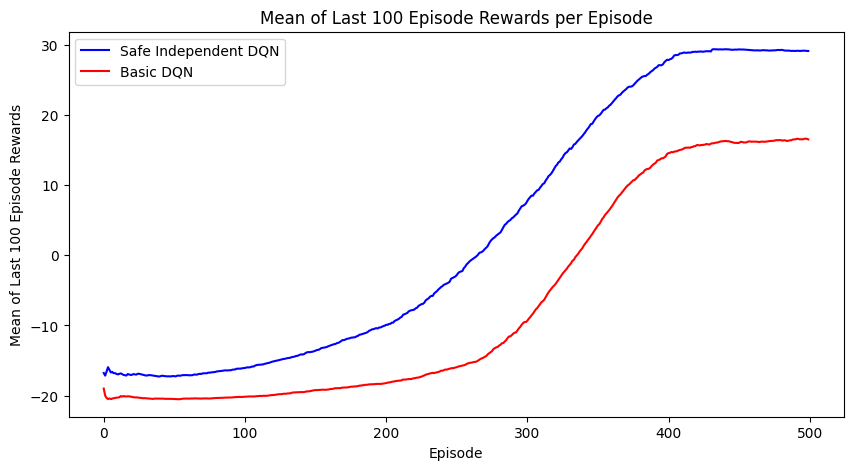

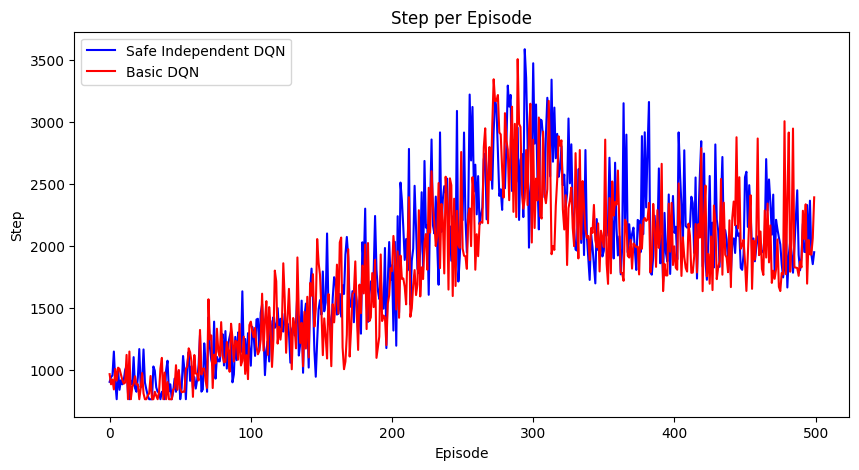

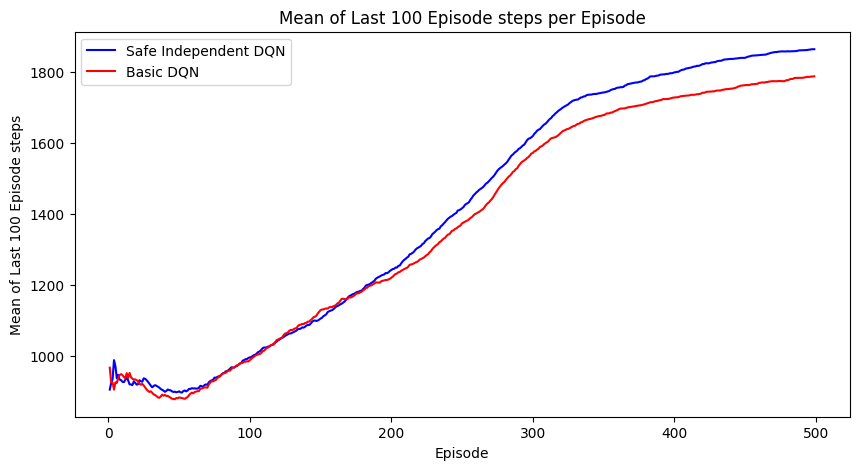

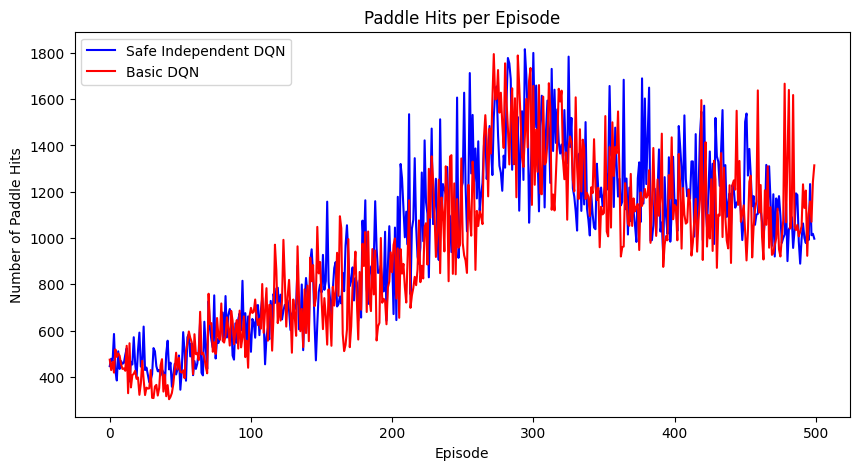

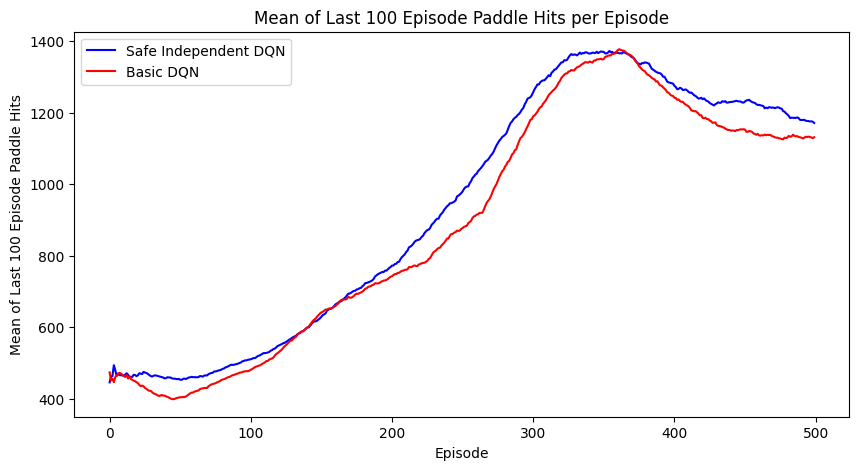

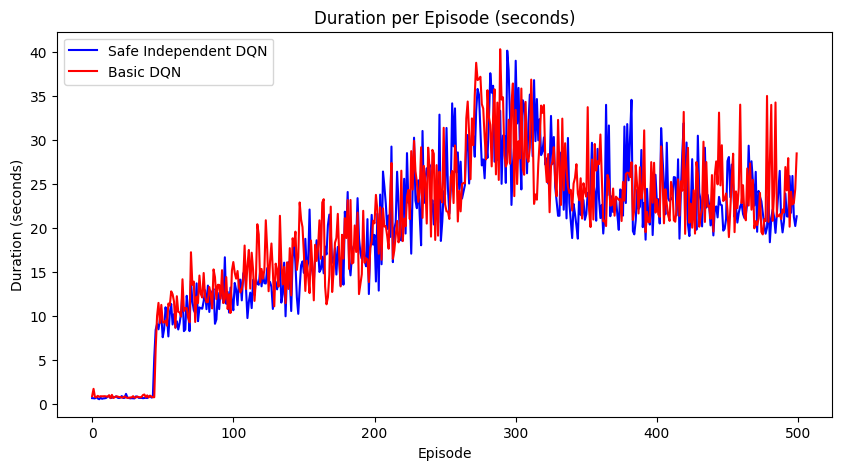

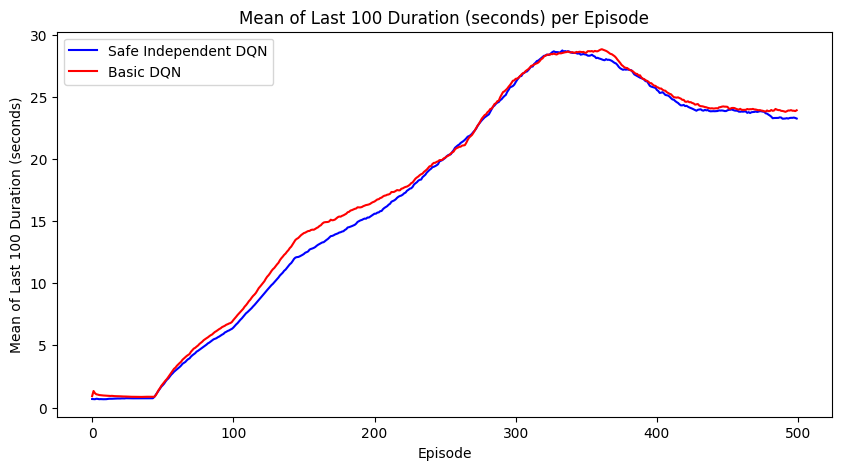

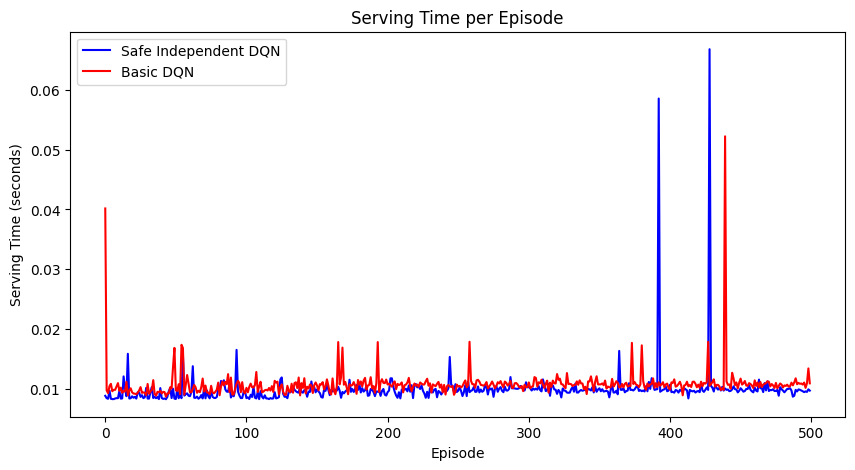

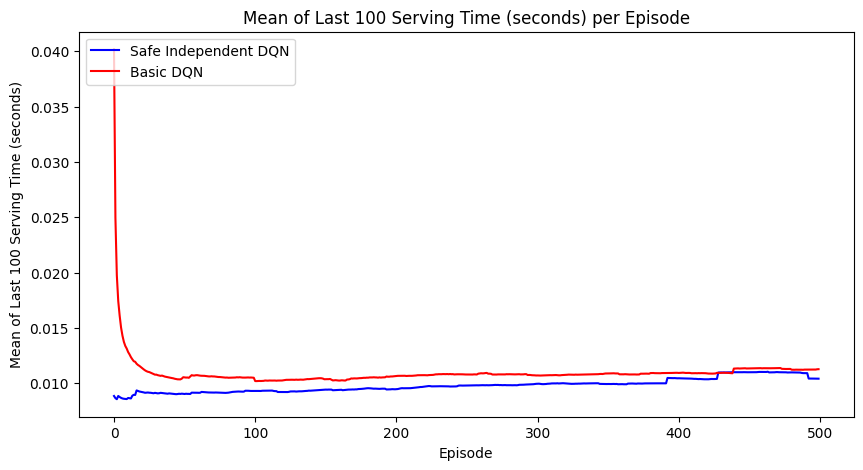

In [51]:
# Plotting comparison with trial6
plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_rewards_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Reward per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_reward, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_reward_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Rewards')
plt.title('Mean of Last 100 Episode Rewards per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Rewards per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_steps, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_steps_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.title('Step per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_steps, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_steps_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode steps')
plt.title('Mean of Last 100 Episode steps per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode steps per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(paddle_hits, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_paddle_hits_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Number of Paddle Hits')
plt.title('Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_paddle_hits, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_paddle_hits_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Episode Paddle Hits')
plt.title('Mean of Last 100 Episode Paddle Hits per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Episode Paddle Hits per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(episode_durations, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_episode_durations_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Duration (seconds)')
plt.title('Duration per Episode (seconds)')
plt.legend(loc="upper left")
plt.savefig('Comparison Duration per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_ep_durations, label = 'Safe Independent DQN', c='b')
plt.plot(First_Method_mean_last_100_ep_durations_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Duration (seconds)')
plt.title('Mean of Last 100 Duration (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Duration (seconds) per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(serving_times, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_serving_times_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Serving Time (seconds)')
plt.title('Serving Time per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Serving time per Episode.png')

plt.figure(figsize=(10,5))
plt.plot(mean_last_100_serving_times, label = "Safe Independent DQN", c='b')
plt.plot(First_Method_mean_last_100_serving_times_trial6, label = "Basic DQN", c='r')
plt.xlabel('Episode')
plt.ylabel('Mean of Last 100 Serving Time (seconds)')
plt.title('Mean of Last 100 Serving Time (seconds) per Episode')
plt.legend(loc="upper left")
plt.savefig('Comparison Mean of Last 100 Serving Time (seconds) per Episode.png')